In [1]:
from __future__ import annotations
import json
from pathlib import Path
from typing import Any, List, Dict, Sequence, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_all_jsons_as_array(folder_path: Union[str, Path], *, encoding: str = "utf-8") -> List[Any]:
    """
    Find all *.json files in `folder_path`, load each file, and concatenate their
    contents into a single list. Additionally, parse filenames like "56_2.json"
    and inject:
      - instance_id: 56
      - target_id: 2

    Rules:
      - If a JSON file contains a list -> for each item:
          - if item is a dict: add ids into the dict
          - else: wrap as {"value": item, "instance_id": ..., "target_id": ...}
        and extend the output with those items.
      - Otherwise (dict/str/number/etc.) -> append one item:
          - if dict: add ids into the dict
          - else: wrap as {"value": data, "instance_id": ..., "target_id": ...}

    Raises:
      FileNotFoundError: if the folder doesn't exist.
      NotADirectoryError: if folder_path is not a directory.
      ValueError: if any JSON file is invalid, or filename doesn't match "<int>_<int>.json".
    """
    folder = Path(folder_path)

    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder}")
    if not folder.is_dir():
        raise NotADirectoryError(f"Not a directory: {folder}")

    out: List[Any] = []
    json_files = sorted(folder.glob("*.json"))  # deterministic order

    for fp in json_files:
        # Parse "<instance>_<target>.json"
        stem = fp.stem  # e.g., "56_2"
        parts = stem.split("_")
        if len(parts) != 2:
            raise ValueError(f"Expected filename like '<instance>_<target>.json', got: {fp.name}")

        try:
            instance_id = int(parts[0])
            target_id = int(parts[1])
        except ValueError as e:
            raise ValueError(f"Filename ids must be integers, got: {fp.name}") from e

        # Load JSON
        try:
            with fp.open("r", encoding=encoding) as f:
                data = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON in {fp}: {e}") from e

        # Attach ids
        if isinstance(data, list):
            for item in data:
                if isinstance(item, dict):
                    item = dict(item)  # avoid mutating original
                    item["instance_id"] = instance_id
                    item["target_id"] = target_id
                    out.append(item)
                else:
                    out.append(
                        {"value": item, "instance_id": instance_id, "target_id": target_id}
                    )
        elif isinstance(data, dict):
            item = dict(data)  # avoid mutating original
            item["instance_id"] = instance_id
            item["target_id"] = target_id
            out.append(item)
        else:
            out.append({"value": data, "instance_id": instance_id, "target_id": target_id})

    return out

In [3]:
f_100_99_pub_sc_ga_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/PubLayNet/size_cond/grouped_all/position')
f_100_99_pub_sc_gp_c = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/PubLayNet/size_cond/grouped_psc/category')
f_100_99_pub_sc_gp_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/PubLayNet/size_cond/grouped_psc/position')
f_100_99_pub_sc_gp_s = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/PubLayNet/size_cond/grouped_psc/size')
f_100_99_pub_sc_px_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/PubLayNet/size_cond/per_xy/position')

f_100_99_rico_sc_ga_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/RICO/size_cond/grouped_all/position')
f_100_99_rico_sc_gp_c = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/RICO/size_cond/grouped_psc/category')
f_100_99_rico_sc_gp_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/RICO/size_cond/grouped_psc/position')
f_100_99_rico_sc_gp_s = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/RICO/size_cond/grouped_psc/size')
f_100_99_rico_sc_px_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/100/99/RICO/size_cond/per_xy/position')

f_50_99_rico_sc_gp_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/50/99/RICO/size_cond/grouped_psc/position')
f_200_99_rico_sc_gp_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/200/99/RICO/size_cond/grouped_psc/position')
f_300_99_rico_sc_gp_p = load_all_jsons_as_array('./vis_traj/LayoutFlow/300/99/RICO/size_cond/grouped_psc/position')

In [4]:
def metrics_mean_table_sorted(datasets):
    import re
    import pandas as pd
    import numpy as np

    def key_fn(name: str) -> int:
        m = re.match(r"f_(\d+)_", name)
        return int(m.group(1)) if m else 10**18

    metrics = ("delta_mean", "diff_mean", "rel_delta_mean")
    rows = []

    for name, items in datasets.items():
        # Collect per-file values for each metric (already "normalized" to top-level,
        # meaning: if x/y exist, we average x and y per file)
        collected = {m: [] for m in metrics}

        for it in items:
            has_xy = (
                isinstance(it, dict)
                and isinstance(it.get("x"), dict)
                and isinstance(it.get("y"), dict)
                and ("x" in it and "y" in it)
            )

            if has_xy:
                for m in metrics:
                    vx = it["x"].get(m, None)
                    vy = it["y"].get(m, None)
                    vals = [v for v in (vx, vy) if v is not None]
                    if vals:
                        collected[m].append(float(np.mean(vals)))
            else:
                for m in metrics:
                    v = it.get(m, None) if isinstance(it, dict) else None
                    if v is not None:
                        collected[m].append(float(v))

        rows.append(
            dict(
                dataset=name,
                n_files=len(items),
                delta_mean=float(np.mean(collected["delta_mean"])) if collected["delta_mean"] else np.nan,
                diff_mean=float(np.mean(collected["diff_mean"])) if collected["diff_mean"] else np.nan,
                rel_delta_mean=float(np.mean(collected["rel_delta_mean"])) if collected["rel_delta_mean"] else np.nan,
            )
        )

    out = pd.DataFrame(rows).set_index("dataset")

    return out.loc[sorted(out.index, key=key_fn)]

In [5]:
influence_mode_summary = metrics_mean_table_sorted({
    "f_100_99_pub_sc_ga_p": f_100_99_pub_sc_ga_p,
    "f_100_99_pub_sc_gp_p": f_100_99_pub_sc_gp_p,
    "f_100_99_pub_sc_px_p": f_100_99_pub_sc_px_p,
    "f_100_99_rico_sc_ga_p": f_100_99_rico_sc_ga_p,
    "f_100_99_rico_sc_gp_p": f_100_99_rico_sc_gp_p,
    "f_100_99_rico_sc_px_p": f_100_99_rico_sc_px_p,
})

print(influence_mode_summary)

                       n_files  delta_mean  diff_mean  rel_delta_mean
dataset                                                              
f_100_99_pub_sc_ga_p       100    0.035177   1.028509        0.243895
f_100_99_pub_sc_gp_p       100    0.035177   1.028509        0.243895
f_100_99_pub_sc_px_p       100    0.023493   0.716067        0.208124
f_100_99_rico_sc_ga_p      100    0.035987   1.275652        0.345745
f_100_99_rico_sc_gp_p      100    0.035987   1.275652        0.345745
f_100_99_rico_sc_px_p      100    0.024703   0.870078        0.170778


In [6]:
inference_steps_summary = metrics_mean_table_sorted({
    "f_50_99_rico_sc_gp_p": f_50_99_rico_sc_gp_p,
    "f_100_99_rico_sc_gp_p": f_100_99_rico_sc_gp_p,
    "f_200_99_rico_sc_gp_p": f_200_99_rico_sc_gp_p,
    "f_300_99_rico_sc_gp_p": f_300_99_rico_sc_gp_p,
})

print(inference_steps_summary)

                       n_files  delta_mean  diff_mean  rel_delta_mean
dataset                                                              
f_50_99_rico_sc_gp_p       100    0.074548   1.275652        0.808711
f_100_99_rico_sc_gp_p      100    0.035987   1.275652        0.345745
f_200_99_rico_sc_gp_p      100    0.018487   1.275652        0.126105
f_300_99_rico_sc_gp_p      100    0.012312   1.275652        0.063684


In [7]:
def plot_avg_attr_dominance(
    runs: Sequence[Dict[str, Any]],
    *,
    title: str = "",
    omit_last: bool = True,          # drops the last timestamp (so 100 -> 99)
    use_abs: bool = True,            # makes dominance comparisons easier if IG can be negative
    element_reduction: str = "mean", # "mean" or "sum" over elements
    file_reduction: str = "mean",    # "mean" or "median" over files
    remove_target_element: bool = False,  # NEW: drop element at target_id per file across all timestamps
) -> pd.DataFrame:
    """
    runs: list of dicts, each dict has key "influences" with shape [T, L, 3]
          where last dim is [position, size, category].

    If remove_target_element=True, for each file we remove the element at index `target_id`
    (read from the dict, e.g. d["target_id"]) across all timestamps for that file before
    aggregating.

    Produces a plot with X-axis timestamps (1..99 if omit_last=True and T=100)
    and returns a DataFrame indexed by timestamp with columns:
      ["position", "size", "category"].
    """
    arrays = []

    for i, d in enumerate(runs):
        if "influences" not in d:
            raise KeyError(f"runs[{i}] missing key 'influences'")

        inf = d["influences"]
        if hasattr(inf, "detach"):  # torch.Tensor
            inf = inf.detach().cpu().numpy()

        inf = np.asarray(inf, dtype=float)

        if inf.ndim != 3 or inf.shape[-1] != 3:
            raise ValueError(
                f"runs[{i}]['influences'] must have shape [T, L, 3], got {inf.shape}"
            )

        if remove_target_element:
            if "target_id" not in d:
                raise KeyError(f"runs[{i}] missing key 'target_id' (needed for remove_target_element=True)")
            tid = int(d["target_id"])
            L_i = inf.shape[1]
            if not (0 <= tid < L_i):
                raise ValueError(f"runs[{i}] target_id={tid} out of bounds for L={L_i}")

            # Remove that element index for ALL timestamps for this file
            keep_idx = np.ones(L_i, dtype=bool)
            keep_idx[tid] = False
            inf = inf[:, keep_idx, :]  # [T, L-1, 3]

        if use_abs:
            inf = np.abs(inf)

        arrays.append(inf)

    # Align by trimming to smallest [T, L] across files (after optional removal)
    T = min(a.shape[0] for a in arrays)
    L = min(a.shape[1] for a in arrays)

    arr = np.stack([a[:T, :L, :] for a in arrays], axis=0)  # [N, T, L, 3]

    if omit_last and arr.shape[1] > 0:
        arr = arr[:, :-1, :, :]  # [N, T-1, L, 3]

    # Reduce over elements
    if element_reduction == "mean":
        per_file = arr.mean(axis=2)  # [N, T', 3]
    elif element_reduction == "sum":
        per_file = arr.sum(axis=2)   # [N, T', 3]
    else:
        raise ValueError("element_reduction must be 'mean' or 'sum'")

    # Reduce over files
    if file_reduction == "mean":
        avg = per_file.mean(axis=0)      # [T', 3]
    elif file_reduction == "median":
        avg = np.median(per_file, axis=0)
    else:
        raise ValueError("file_reduction must be 'mean' or 'median'")

    # Build DataFrame with timestamps 1..T'
    T_prime = avg.shape[0]
    ts = np.arange(1, T_prime + 1)
    df = pd.DataFrame(avg, index=ts, columns=["position", "size", "category"])

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(df.index, df["position"], label="position")
    plt.plot(df.index, df["size"], label="size")
    plt.plot(df.index, df["category"], label="category")
    plt.xlabel("Timestamp")
    plt.ylabel("Average influence" + (" (abs)" if use_abs else ""))
    
    if title:
        plt.title(title)
        
    plt.legend()
    plt.tight_layout()
    plt.show()

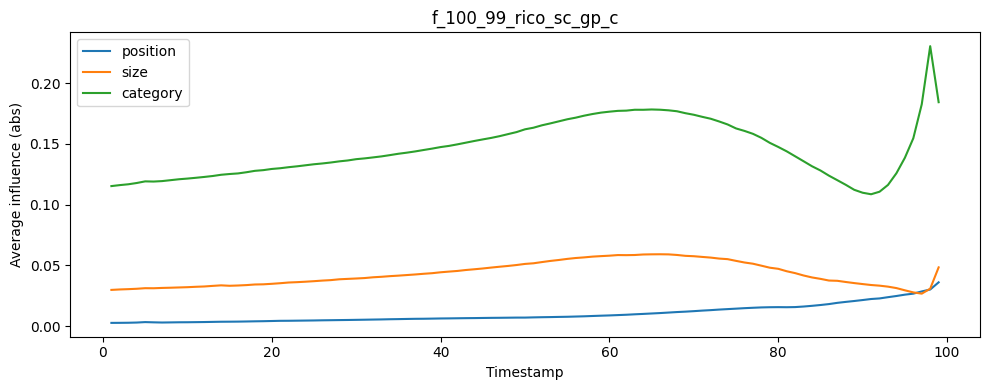

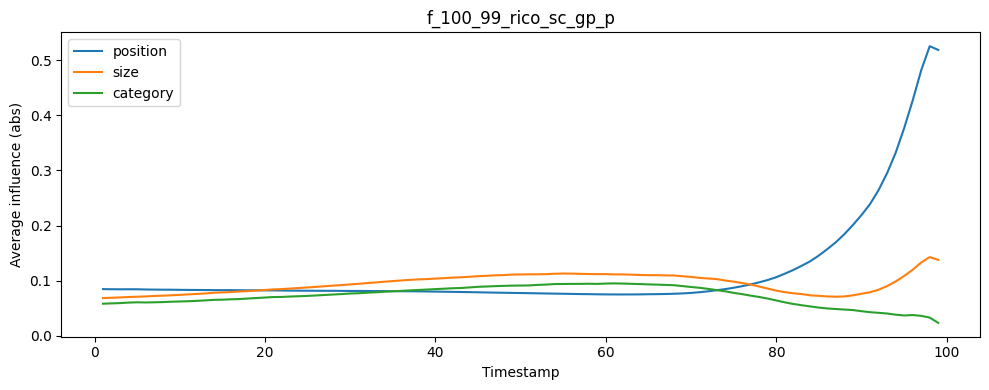

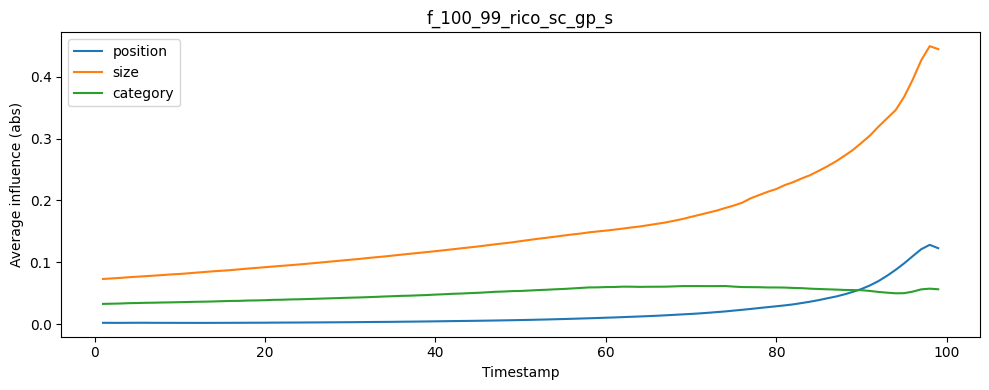

In [8]:
plot_avg_attr_dominance(f_100_99_rico_sc_gp_c, title="f_100_99_rico_sc_gp_c")
plot_avg_attr_dominance(f_100_99_rico_sc_gp_p, title="f_100_99_rico_sc_gp_p")
plot_avg_attr_dominance(f_100_99_rico_sc_gp_s, title="f_100_99_rico_sc_gp_s")

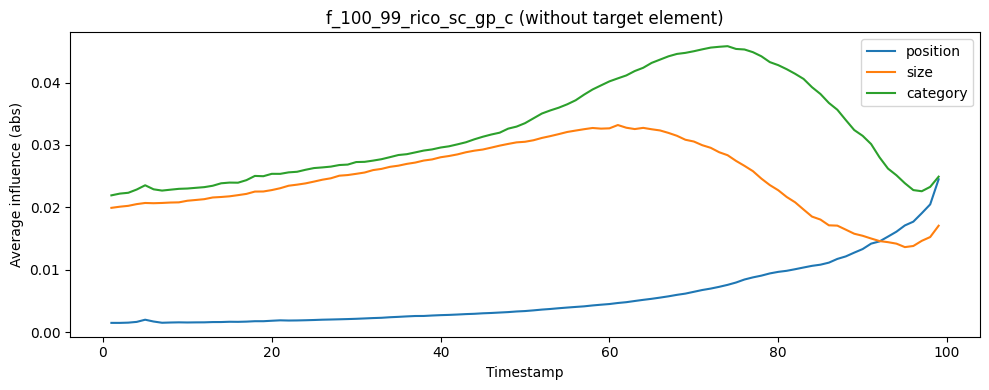

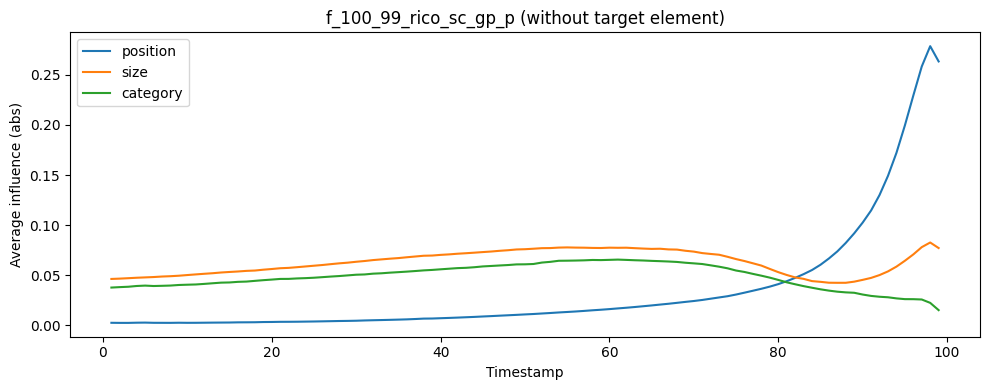

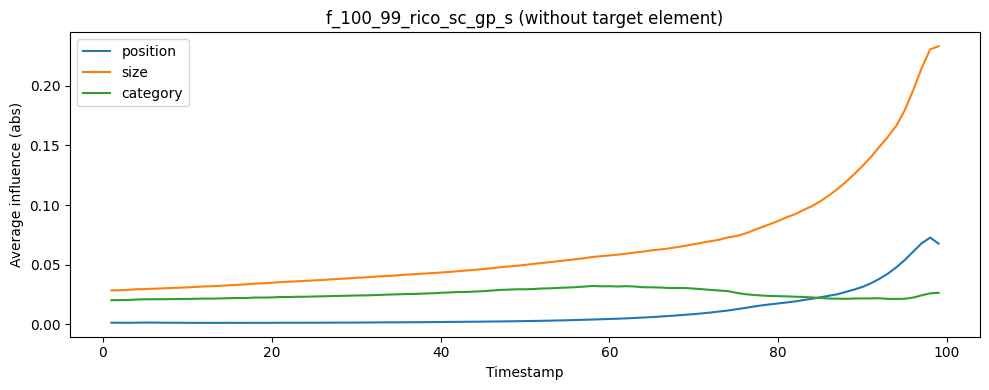

In [9]:
plot_avg_attr_dominance(f_100_99_rico_sc_gp_c, title="f_100_99_rico_sc_gp_c (without target element)", remove_target_element=True)
plot_avg_attr_dominance(f_100_99_rico_sc_gp_p, title="f_100_99_rico_sc_gp_p (without target element)", remove_target_element=True)
plot_avg_attr_dominance(f_100_99_rico_sc_gp_s, title="f_100_99_rico_sc_gp_s (without target element)", remove_target_element=True)

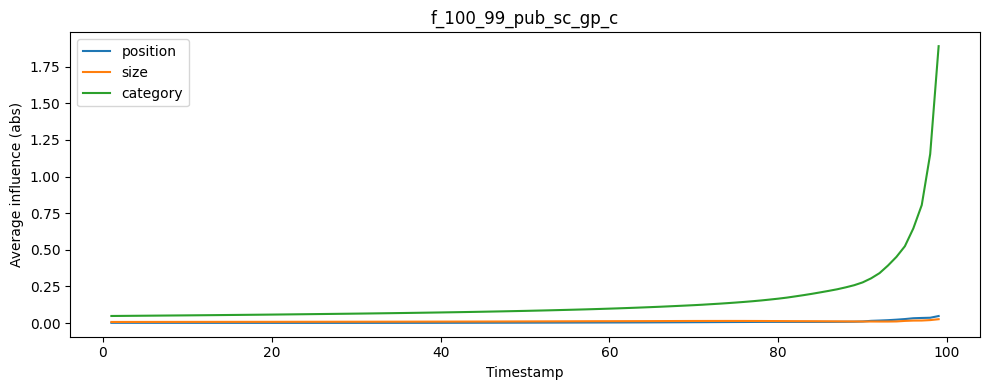

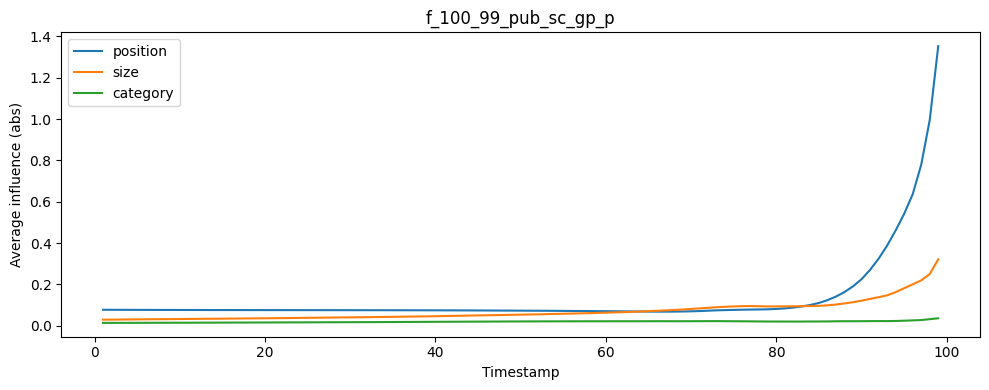

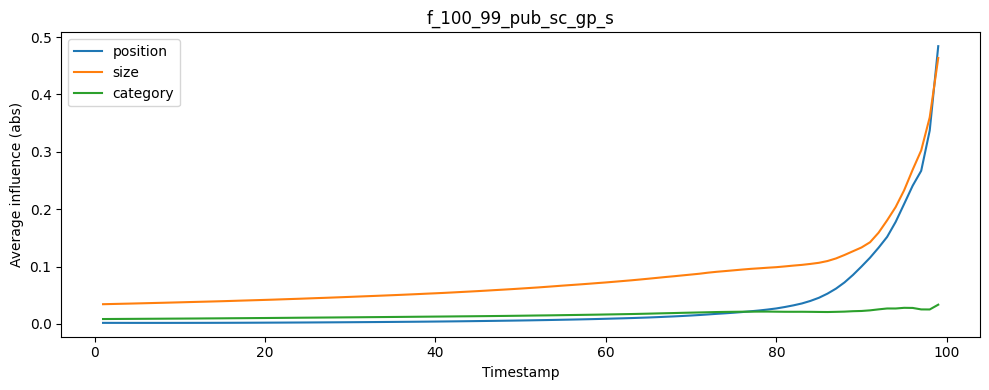

In [10]:
plot_avg_attr_dominance(f_100_99_pub_sc_gp_c, title="f_100_99_pub_sc_gp_c")
plot_avg_attr_dominance(f_100_99_pub_sc_gp_p, title="f_100_99_pub_sc_gp_p")
plot_avg_attr_dominance(f_100_99_pub_sc_gp_s, title="f_100_99_pub_sc_gp_s")

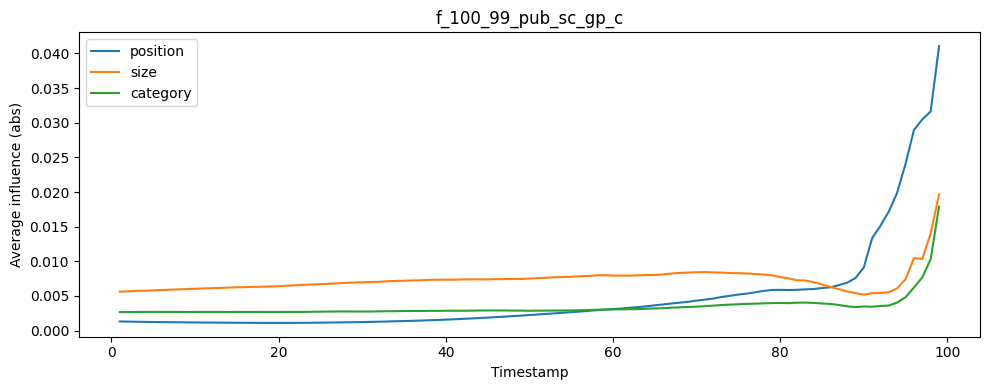

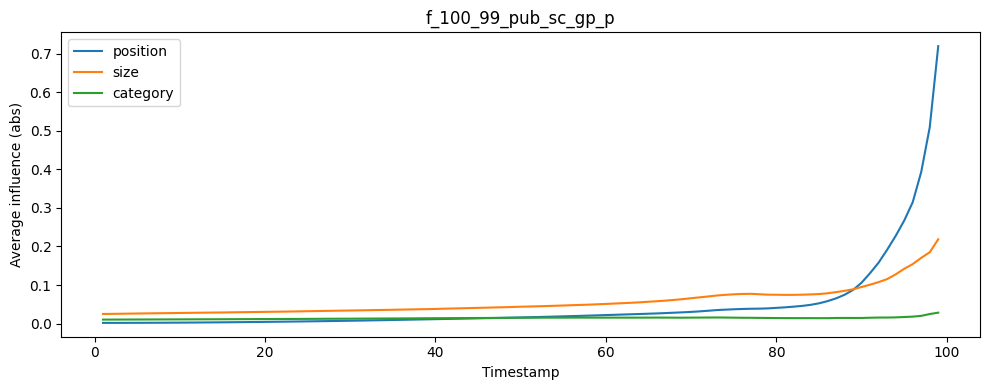

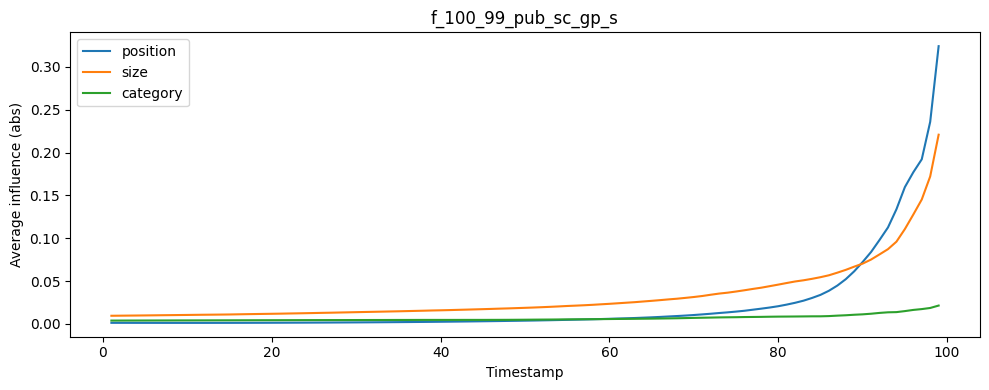

In [11]:
plot_avg_attr_dominance(f_100_99_pub_sc_gp_c, title="f_100_99_pub_sc_gp_c", remove_target_element=True)
plot_avg_attr_dominance(f_100_99_pub_sc_gp_p, title="f_100_99_pub_sc_gp_p", remove_target_element=True)
plot_avg_attr_dominance(f_100_99_pub_sc_gp_s, title="f_100_99_pub_sc_gp_s", remove_target_element=True)